In [1]:
import networkx as nx
from pydantic import BaseModel, Field, ValidationError
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.callbacks import get_openai_callback
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import UnstructuredPDFLoader, PyPDFLoader

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Add the parent directory to the path since we work with notebooks
import json
import subprocess
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import List, Tuple, Dict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import spacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example
import random
import heapq


from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np

from spacy.cli import download
from spacy.lang.en import English

from src.utils.ner import LLMNamedEntityRecognizer

# Load environment variables from a .env file
load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
# Define the DocumentProcessor class
class DocumentProcessor:
    def __init__(self):
        """
        Initializes the DocumentProcessor with a text splitter and OpenAI embeddings.
        
        Attributes:
        - text_splitter: An instance of RecursiveCharacterTextSplitter with specified chunk size and overlap.
        - embeddings: An instance of OpenAIEmbeddings used for embedding documents.
        """
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        self.embeddings = OpenAIEmbeddings()

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into smaller chunks and creating a vector store.
        
        Args:
        - documents (list of str): A list of documents to be processed.
        
        Returns:
        - tuple: A tuple containing:
          - splits (list of str): The list of split document chunks.
          - vector_store (FAISS): A FAISS vector store created from the split document chunks and their embeddings.
        """
        splits = self.text_splitter.split_documents(documents)
        vector_store = FAISS.from_documents(splits, self.embeddings)
        return splits, vector_store

    def create_embeddings_batch(self, texts, batch_size=32):
        """
        Creates embeddings for a list of texts in batches.
        
        Args:
        - texts (list of str): A list of texts to be embedded.
        - batch_size (int, optional): The number of texts to process in each batch. Default is 32.
        
        Returns:
        - numpy.ndarray: An array of embeddings for the input texts.
        """
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            batch_embeddings = self.embeddings.embed_documents(batch)
            embeddings.extend(batch_embeddings)
        return np.array(embeddings)

    def compute_similarity_matrix(self, embeddings):
        """
        Computes a cosine similarity matrix for a given set of embeddings.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings.
        
        Returns:
        - numpy.ndarray: A cosine similarity matrix for the input embeddings.
        """
        return cosine_similarity(embeddings)

In [3]:
# Define the Concepts class
class Concepts(BaseModel):
    #--------------------------------------------
    # What are we doing here?
    # With Pydantic we define a data structure that defines, in turn,
    # how an output from an LLM should look like and what it actually is.
    # So we could instead use a prompt that tells the llm, in this case, to
    # 'return the output as a List of strings that contains the different concepts'.
    # Usually, in LangChain, we use such BaseModel-Classes together with an LLM instance and
    # the method `.with_structured_output()`.
    concepts_list: List[str] = Field(description="List of concepts")

# Define the KnowledgeGraph class
class KnowledgeGraph:
    def __init__(self, entity_types: bool=True):
        """
        Initializes the KnowledgeGraph with a graph, lemmatizer, and NLP model.
        
        Args:
        - entity_types (bool): If standard entity types shall be used (True) or not (False). Defaults to 'True'.
        
        Attributes:
        - graph: An instance of a networkx Graph.
        - lemmatizer: An instance of WordNetLemmatizer.
        - concept_cache: A dictionary to cache extracted concepts.
        - nlp: An instance of a spaCy NLP model.
        - edges_threshold: A float value that sets the threshold for adding edges based on similarity.
        """
        self.graph = nx.Graph()
        self.lemmatizer = WordNetLemmatizer()
        self.concept_cache = {}
        self.nlp = self._load_spacy_model()
        self.edges_threshold = 0.8
        self.entity_types = entity_types

    def build_graph(self, splits, llm, embedding_model):
        """
        Builds the knowledge graph by adding nodes, creating embeddings, extracting concepts, and adding edges.
        
        Args:
        - splits (list): A list of document splits.
        - llm: An instance of a large language model.
        - embedding_model: An instance of an embedding model.
        
        Returns:
        - None
        """
        self._add_nodes(splits)
        embeddings = self._create_embeddings(splits, embedding_model)
        self._extract_concepts(splits, llm)
        self._add_edges(embeddings)
        self._save_graph_locally()

    def _add_nodes(self, splits):
        """
        Adds nodes to the graph from the document splits.
        
        Args:
        - splits (list): A list of document splits.
        
        Returns:
        - None
        """
        for i, split in enumerate(splits):
            self.graph.add_node(i, content=split.page_content)

    def _create_embeddings(self, splits, embedding_model):
        """
        Creates embeddings for the document splits using the embedding model.
        
        Args:
        - splits (list): A list of document splits.
        - embedding_model: An instance of an embedding model.
        
        Returns:
        - numpy.ndarray: An array of embeddings for the document splits.
        """
        texts = [split.page_content for split in splits]
        return embedding_model.embed_documents(texts)

    def _compute_similarities(self, embeddings):
        """
        Computes the cosine similarity matrix for the embeddings.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings.
        
        Returns:
        - numpy.ndarray: A cosine similarity matrix for the embeddings.
        """
        return cosine_similarity(embeddings)

    def _load_spacy_model(self):
        """
        Loads the spaCy NLP model, downloading it if necessary.
        
        Args:
        - None
        
        Returns:
        - spacy.Language: An instance of a spaCy NLP model.
        """
        try:
            return spacy.load("en_core_web_sm")
        except OSError:
            print("downloading spaCy model via Linux console: python3 -m spacy download...")
            subprocess.run("python3 -m spacy download en_core_web_sm", shell=True)
            #model = spacy.load("de_core_news_sm")
            # locate the model where it is stored with 'model._path' 
            return spacy.load("en_core_web_sm")

    def _run_ner_with_llm(self, content, model_name: str="gpt-4o-mini"):
        ner = LLMNamedEntityRecognizer(model_name=model_name)
        if self.entity_types:
            _entity_types = ["PERSON", "ORGANIZATION", "MILITARY_UNIT", "GPE", "DATE", "TIME"]
        else:
            # extract all possible entities. The LLM decides!!!
            _entity_types = None
        try:
            entities, json_output = ner.extract_entities(text=content, entity_types=_entity_types)
            # print(f"Entities in JSON-Format: {json_output}")
            # print("Entity MILITARY_UNIT:{}".format(entities.MILITARY_UNIT))
            return entities, json_output
        except ValidationError as e:
            raise ValueError(f"Error extracting entities: {e}")
    
    def _extract_concepts_and_entities(self, content, llm):
        """
        Extracts concepts and named entities from the content using spaCy and a large language model.
        
        Args:
        - content (str): The content from which to extract concepts and entities.
        - llm: An instance of a large language model.
        
        Returns:
        - list: A list of extracted concepts and entities.
        """
        if content in self.concept_cache:
            return self.concept_cache[content]
        
        # Extract named entities using spaCy
        # doc = self.nlp(content)
        # print("AVAILABLE ENTITIES of SpaCy: {}".format(doc.ents))
        # named_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "DATE"]]
        entity_dict, json_output = self._run_ner_with_llm(content=content)
        # transform json_output-string into dict
        named_entities = []
        d = json.loads(json_output)
        for k in d.keys():
            if k != "OTHER":
                print("Entity key is:{}".format(k))
                entity_list = d[k]
                for i in entity_list:
                    named_entities.append(i)
            else:
                print("Entity key is 'OTHER'.")
                entity_dict = d[k]
                if entity_dict:
                    for ek in entity_dict.keys():
                        entity_list = entity_dict[ek]
                        for j in entity_list:
                            named_entities.append(j)
        
        # Extract general concepts using LLM
        concept_extraction_prompt = PromptTemplate(
            input_variables=["text"],
            template="Extract key concepts (excluding named entities) from the following text:\n\n{text}\n\nKey concepts:"
        )
        concept_chain = concept_extraction_prompt | llm.with_structured_output(Concepts) # apply the pydantic model for the output defined above
        general_concepts = concept_chain.invoke({"text": content}).concepts_list # through the defined pydantic model we are able to retrieve the list of concepts.
        
        # Combine named entities and general concepts
        all_concepts = list(set(named_entities + general_concepts))
        
        self.concept_cache[content] = all_concepts
        return all_concepts

    def _extract_concepts(self, splits, llm):
        """
        Extracts concepts for all document splits using multi-threading.
        
        Args:
        - splits (list): A list of document splits.
        - llm: An instance of a large language model.
        
        Returns:
        - None
        """
        with ThreadPoolExecutor() as executor:
            future_to_node = {executor.submit(self._extract_concepts_and_entities, split.page_content, llm): i 
                              for i, split in enumerate(splits)}
            
            for future in tqdm(as_completed(future_to_node), total=len(splits), desc="Extracting concepts and entities"):
                node = future_to_node[future]
                concepts = future.result()
                self.graph.nodes[node]['concepts'] = concepts

    def _add_edges(self, embeddings):
        """
        Adds edges to the graph based on the similarity of embeddings and shared concepts.
        
        Args:
        - embeddings (numpy.ndarray): An array of embeddings for the document splits.
        
        Returns:
        - None
        """
        similarity_matrix = self._compute_similarities(embeddings)
        num_nodes = len(self.graph.nodes)
        
        for node1 in tqdm(range(num_nodes), desc="Adding edges"):
            for node2 in range(node1 + 1, num_nodes):
                similarity_score = similarity_matrix[node1][node2]
                if similarity_score > self.edges_threshold:
                    shared_concepts = set(self.graph.nodes[node1]['concepts']) & set(self.graph.nodes[node2]['concepts'])
                    edge_weight = self._calculate_edge_weight(node1, node2, similarity_score, shared_concepts)
                    self.graph.add_edge(node1, node2, weight=edge_weight, 
                                        similarity=similarity_score,
                                        shared_concepts=list(shared_concepts))
    def _save_graph_locally(self):
        import pickle
        DATA_DIR = os.path.join(os.getcwd(), 'data/knowledge_graph')
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR, exist_ok=True)
        # save graph object to file
        pickle.dump(self.graph, open(f"{DATA_DIR}/knowledge_graph.pkl", "wb"))

    def _calculate_edge_weight(self, node1, node2, similarity_score, shared_concepts, alpha=0.7, beta=0.3):
        """
        Calculates the weight of an edge based on similarity score and shared concepts.
        
        Args:
        - node1 (int): The first node.
        - node2 (int): The second node.
        - similarity_score (float): The similarity score between the nodes.
        - shared_concepts (set): The set of shared concepts between the nodes.
        - alpha (float, optional): The weight of the similarity score. Default is 0.7.
        - beta (float, optional): The weight of the shared concepts. Default is 0.3.
        
        Returns:
        - float: The calculated weight of the edge.
        """
        max_possible_shared = min(len(self.graph.nodes[node1]['concepts']), len(self.graph.nodes[node2]['concepts']))
        normalized_shared_concepts = len(shared_concepts) / max_possible_shared if max_possible_shared > 0 else 0
        return alpha * similarity_score + beta * normalized_shared_concepts

    def _lemmatize_concept(self, concept):
        """
        Lemmatizes a given concept.
        
        Args:
        - concept (str): The concept to be lemmatized.
        
        Returns:
        - str: The lemmatized concept.
        """
        return ' '.join([self.lemmatizer.lemmatize(word) for word in concept.lower().split()])

In [4]:
# Define the AnswerCheck class
class AnswerCheck(BaseModel):
    is_complete: bool = Field(description="Whether the current context provides a complete answer to the query")
    answer: str = Field(description="The current answer based on the context, if any")

# Define the QueryEngine class
class QueryEngine:
    def __init__(self, vector_store, knowledge_graph, llm):
        self.vector_store = vector_store
        self.knowledge_graph = knowledge_graph
        self.llm = llm
        self.max_context_length = 4000
        self.answer_check_chain = self._create_answer_check_chain()

    def _create_answer_check_chain(self):
        """
        Creates a chain to check if the context provides a complete answer to the query.
        
        Args:
        - None
        
        Returns:
        - Chain: A chain to check if the context provides a complete answer.
        """
        answer_check_prompt = PromptTemplate(
            input_variables=["query", "context"],
            template="Given the query: '{query}'\n\nAnd the current context:\n{context}\n\nDoes this context provide a complete answer to the query? If yes, provide the answer. If no, state that the answer is incomplete.\n\nIs complete answer (Yes/No):\nAnswer (if complete):"
        )
        return answer_check_prompt | self.llm.with_structured_output(AnswerCheck)

    def _check_answer(self, query: str, context: str) -> Tuple[bool, str]:
        """
        Checks if the current context provides a complete answer to the query.
        
        Args:
        - query (str): The query to be answered.
        - context (str): The current context.
        
        Returns:
        - tuple: A tuple containing:
          - is_complete (bool): Whether the context provides a complete answer.
          - answer (str): The answer based on the context, if complete.
        """
        response = self.answer_check_chain.invoke({"query": query, "context": context})
        return response.is_complete, response.answer

  

    def _expand_context(self, query: str, relevant_docs) -> Tuple[str, List[int], Dict[int, str], str]:
        """
        Expands the context by traversing the knowledge graph using a Dijkstra-like approach.
        
        This method implements a modified version of Dijkstra's algorithm to explore the knowledge graph,
        prioritizing the most relevant and strongly connected information. The algorithm works as follows:

        1. Initialize:
           - Start with nodes corresponding to the most relevant documents.
           - Use a priority queue to manage the traversal order, where priority is based on connection strength.
           - Maintain a dictionary of best known "distances" (inverse of connection strengths) to each node.

        2. Traverse:
           - Always explore the node with the highest priority (strongest connection) next.
           - For each node, check if we've found a complete answer.
           - Explore the node's neighbors, updating their priorities if a stronger connection is found.

        3. Concept Handling:
           - Track visited concepts to guide the exploration towards new, relevant information.
           - Expand to neighbors only if they introduce new concepts.

        4. Termination:
           - Stop if a complete answer is found.
           - Continue until the priority queue is empty (all reachable nodes explored).

        This approach ensures that:
        - We prioritize the most relevant and strongly connected information.
        - We explore new concepts systematically.
        - We find the most relevant answer by following the strongest connections in the knowledge graph.

        Args:
        - query (str): The query to be answered.
        - relevant_docs (List[Document]): A list of relevant documents to start the traversal.

        Returns:
        - tuple: A tuple containing:
          - expanded_context (str): The accumulated context from traversed nodes.
          - traversal_path (List[int]): The sequence of node indices visited.
          - filtered_content (Dict[int, str]): A mapping of node indices to their content.
          - final_answer (str): The final answer found, if any.
        """
        # Initialize variables
        expanded_context = ""
        traversal_path = []
        visited_concepts = set()
        filtered_content = {}
        final_answer = ""
        
        priority_queue = []
        distances = {}  # Stores the best known "distance" (inverse of connection strength) to each node
        
        print("\nTraversing the knowledge graph:")
        
        # Initialize priority queue with closest nodes from relevant docs
        for doc in relevant_docs:
            # Find the most similar node in the knowledge graph for each relevant document
            closest_nodes = self.vector_store.similarity_search_with_score(doc.page_content, k=1)
            closest_node_content, similarity_score = closest_nodes[0]
            
            # Get the corresponding node in our knowledge graph
            closest_node = next(n for n in self.knowledge_graph.graph.nodes if self.knowledge_graph.graph.nodes[n]['content'] == closest_node_content.page_content)
            
            # Initialize priority (inverse of similarity score for min-heap behavior)
            priority = 1 / similarity_score
            heapq.heappush(priority_queue, (priority, closest_node))
            distances[closest_node] = priority
        
        step = 0
        while priority_queue:
            # Get the node with the highest priority (lowest distance value)
            current_priority, current_node = heapq.heappop(priority_queue)
            
            # Skip if we've already found a better path to this node
            if current_priority > distances.get(current_node, float('inf')):
                continue
            
            if current_node not in traversal_path:
                step += 1
                traversal_path.append(current_node)
                node_content = self.knowledge_graph.graph.nodes[current_node]['content']
                node_concepts = self.knowledge_graph.graph.nodes[current_node]['concepts']
                
                # Add node content to our accumulated context
                filtered_content[current_node] = node_content
                expanded_context += "\n" + node_content if expanded_context else node_content
                
                # Log the current step for debugging and visualization
                print(f"\nStep {step} - Node {current_node}:")
                print(f"Content: {node_content[:100]}...") 
                print(f"Concepts: {', '.join(node_concepts)}")
                print("-" * 50)
                
                # Check if we have a complete answer with the current context
                is_complete, answer = self._check_answer(query, expanded_context)
                if is_complete:
                    final_answer = answer
                    break
                
                # Process the concepts of the current node
                node_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in node_concepts)
                if not node_concepts_set.issubset(visited_concepts):
                    visited_concepts.update(node_concepts_set)
                    
                    # Explore neighbors
                    for neighbor in self.knowledge_graph.graph.neighbors(current_node):
                        edge_data = self.knowledge_graph.graph[current_node][neighbor]
                        edge_weight = edge_data['weight']
                        
                        # Calculate new distance (priority) to the neighbor
                        # Note: We use 1 / edge_weight because higher weights mean stronger connections
                        distance = current_priority + (1 / edge_weight)
                        
                        # If we've found a stronger connection to the neighbor, update its distance
                        if distance < distances.get(neighbor, float('inf')):
                            distances[neighbor] = distance
                            heapq.heappush(priority_queue, (distance, neighbor))
                            
                            # Process the neighbor node if it's not already in our traversal path
                            if neighbor not in traversal_path:
                                step += 1
                                traversal_path.append(neighbor)
                                neighbor_content = self.knowledge_graph.graph.nodes[neighbor]['content']
                                neighbor_concepts = self.knowledge_graph.graph.nodes[neighbor]['concepts']
                                
                                filtered_content[neighbor] = neighbor_content
                                expanded_context += "\n" + neighbor_content if expanded_context else neighbor_content
                                
                                # Log the neighbor node information
                                print(f"\nStep {step} - Node {neighbor} (neighbor of {current_node}):")
                                print(f"Content: {neighbor_content[:100]}...")
                                print(f"Concepts: {', '.join(neighbor_concepts)}")
                                print("-" * 50)
                                
                                # Check if we have a complete answer after adding the neighbor's content
                                is_complete, answer = self._check_answer(query, expanded_context)
                                if is_complete:
                                    final_answer = answer
                                    break
                                
                                # Process the neighbor's concepts
                                neighbor_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in neighbor_concepts)
                                if not neighbor_concepts_set.issubset(visited_concepts):
                                    visited_concepts.update(neighbor_concepts_set)
                
                # If we found a final answer, break out of the main loop
                if final_answer:
                    break

        # If we haven't found a complete answer, generate one using the LLM
        if not final_answer:
            print("\nGenerating final answer...")
            response_prompt = PromptTemplate(
                input_variables=["query", "context"],
                template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
            )
            response_chain = response_prompt | self.llm
            input_data = {"query": query, "context": expanded_context}
            final_answer = response_chain.invoke(input_data)

        return expanded_context, traversal_path, filtered_content, final_answer

    def query(self, query: str) -> Tuple[str, List[int], Dict[int, str]]:
        """
        Processes a query by retrieving relevant documents, expanding the context, and generating the final answer.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - tuple: A tuple containing:
          - final_answer (str): The final answer to the query.
          - traversal_path (list): The traversal path of nodes in the knowledge graph.
          - filtered_content (dict): The filtered content of nodes.
        """
        with get_openai_callback() as cb:
            print(f"\nProcessing query: {query}")
            relevant_docs = self._retrieve_relevant_documents(query)
            expanded_context, traversal_path, filtered_content, final_answer = self._expand_context(query, relevant_docs)
            
            if not final_answer:
                print("\nGenerating final answer...")
                response_prompt = PromptTemplate(
                    input_variables=["query", "context"],
                    template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
                )
                
                response_chain = response_prompt | self.llm
                input_data = {"query": query, "context": expanded_context}
                response = response_chain.invoke(input_data)
                final_answer = response
            else:
                print("\nComplete answer found during traversal.")
            
            print(f"\nFinal Answer: {final_answer}")
            print(f"\nTotal Tokens: {cb.total_tokens}")
            print(f"Prompt Tokens: {cb.prompt_tokens}")
            print(f"Completion Tokens: {cb.completion_tokens}")
            print(f"Total Cost (USD): ${cb.total_cost}")
        
        return final_answer, traversal_path, filtered_content

    def _retrieve_relevant_documents(self, query: str):
        """
        Retrieves relevant documents based on the query using the vector store.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - list: A list of relevant documents.
        """
        print("\nRetrieving relevant documents...")
        retriever = self.vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
        compressor = LLMChainExtractor.from_llm(self.llm)
        compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)
        return compression_retriever.invoke(query)

In [5]:
# Define the Visualizer class
class Visualizer:
    @staticmethod
    def visualize_traversal(graph, traversal_path):
        """
        Visualizes the traversal path on the knowledge graph with nodes, edges, and traversal path highlighted.

        Args:
        - graph (networkx.Graph): The knowledge graph containing nodes and edges.
        - traversal_path (list of int): The list of node indices representing the traversal path.

        Returns:
        - None
        """
        traversal_graph = nx.DiGraph()
        
        # Add nodes and edges from the original graph
        for node in graph.nodes():
            traversal_graph.add_node(node)
        for u, v, data in graph.edges(data=True):
            traversal_graph.add_edge(u, v, **data)
        
        fig, ax = plt.subplots(figsize=(16, 12))
        
        # Generate positions for all nodes
        pos = nx.spring_layout(traversal_graph, k=1, iterations=50)
        
        # Draw regular edges with color based on weight
        edges = traversal_graph.edges()
        edge_weights = [traversal_graph[u][v].get('weight', 0.5) for u, v in edges]
        nx.draw_networkx_edges(traversal_graph, pos, 
                               edgelist=edges,
                               edge_color=edge_weights,
                               edge_cmap=plt.cm.Blues,
                               width=2,
                               ax=ax)
        
        # Draw nodes
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               node_color='lightblue',
                               node_size=3000,
                               ax=ax)
        
        # Draw traversal path with curved arrows
        edge_offset = 0.1
        for i in range(len(traversal_path) - 1):
            start = traversal_path[i]
            end = traversal_path[i + 1]
            start_pos = pos[start]
            end_pos = pos[end]
            
            # Calculate control point for curve
            mid_point = ((start_pos[0] + end_pos[0]) / 2, (start_pos[1] + end_pos[1]) / 2)
            control_point = (mid_point[0] + edge_offset, mid_point[1] + edge_offset)
            
            # Draw curved arrow
            arrow = patches.FancyArrowPatch(start_pos, end_pos,
                                            connectionstyle=f"arc3,rad={0.3}",
                                            color='red',
                                            arrowstyle="->",
                                            mutation_scale=20,
                                            linestyle='--',
                                            linewidth=2,
                                            zorder=4)
            ax.add_patch(arrow)
        
        # Prepare labels for the nodes
        labels = {}
        for i, node in enumerate(traversal_path):
            concepts = graph.nodes[node].get('concepts', [])
            label = f"{i + 1}. {concepts[0] if concepts else ''}"
            labels[node] = label
        
        for node in traversal_graph.nodes():
            if node not in labels:
                concepts = graph.nodes[node].get('concepts', [])
                labels[node] = concepts[0] if concepts else ''
        
        # Draw labels
        nx.draw_networkx_labels(traversal_graph, pos, labels, font_size=8, font_weight="bold", ax=ax)
        
        # Highlight start and end nodes
        start_node = traversal_path[0]
        end_node = traversal_path[-1]
        
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               nodelist=[start_node], 
                               node_color='lightgreen', 
                               node_size=3000,
                               ax=ax)
        
        nx.draw_networkx_nodes(traversal_graph, pos, 
                               nodelist=[end_node], 
                               node_color='lightcoral', 
                               node_size=3000,
                               ax=ax)
        
        ax.set_title("Graph Traversal Flow")
        ax.axis('off')
        
        # Add colorbar for edge weights
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Edge Weight', rotation=270, labelpad=15)
        
        # Add legend
        regular_line = plt.Line2D([0], [0], color='blue', linewidth=2, label='Regular Edge')
        traversal_line = plt.Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Traversal Path')
        start_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='Start Node')
        end_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=15, label='End Node')
        legend = plt.legend(handles=[regular_line, traversal_line, start_point, end_point], loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
        legend.get_frame().set_alpha(0.8)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_filtered_content(traversal_path, filtered_content):
        """
        Prints the filtered content of visited nodes in the order of traversal.

        Args:
        - traversal_path (list of int): The list of node indices representing the traversal path.
        - filtered_content (dict of int: str): A dictionary mapping node indices to their filtered content.

        Returns:
        - None
        """
        print("\nFiltered content of visited nodes in order of traversal:")
        for i, node in enumerate(traversal_path):
            print(f"\nStep {i + 1} - Node {node}:")
            print(f"Filtered Content: {filtered_content.get(node, 'No filtered content available')[:200]}...")  # Print first 200 characters
            print("-" * 50)

In [6]:
class GraphRAG:
    def __init__(self):
        """
        Initializes the GraphRAG system with components for document processing, knowledge graph construction,
        querying, and visualization.
        
        Attributes:
        - llm: An instance of a large language model (LLM) for generating responses.
        - embedding_model: An instance of an embedding model for document embeddings.
        - document_processor: An instance of the DocumentProcessor class for processing documents.
        - knowledge_graph: An instance of the KnowledgeGraph class for building and managing the knowledge graph.
        - query_engine: An instance of the QueryEngine class for handling queries (initialized as None).
        - visualizer: An instance of the Visualizer class for visualizing the knowledge graph traversal.
        """
        self.llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini", max_tokens=4000)
        self.embedding_model = OpenAIEmbeddings()
        self.document_processor = DocumentProcessor()
        self.knowledge_graph = KnowledgeGraph(entity_types=True)
        self.query_engine = None
        self.visualizer = Visualizer()

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into chunks, embedding them, and building a knowledge graph.
        
        Args:
        - documents (list of str): A list of documents to be processed.
        
        Returns:
        - None
        """
        splits, vector_store = self.document_processor.process_documents(documents)
        self.knowledge_graph.build_graph(splits, self.llm, self.embedding_model)
        self.query_engine = QueryEngine(vector_store, self.knowledge_graph, self.llm)

    def query(self, query: str):
        """
        Handles a query by retrieving relevant information from the knowledge graph and visualizing the traversal path.
        
        Args:
        - query (str): The query to be answered.
        
        Returns:
        - str: The response to the query.
        """
        response, traversal_path, filtered_content = self.query_engine.query(query)
        
        if traversal_path:
            self.visualizer.visualize_traversal(self.knowledge_graph.graph, traversal_path)
        else:
            print("No traversal path to visualize.")
        
        return response

In [7]:
path = "./src/data/20200414_IMF_Preliminary World Economic Outlook Report.pdf"
loader = PyPDFLoader(path)
docs = loader.load()

In [8]:
graph_rag = GraphRAG()

In [9]:
graph_rag.process_documents(docs)

Extracting concepts and entities:   0%|          | 0/171 [00:00<?, ?it/s]

Final Response:
PERSON=[] GPE=['world'] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 658
Prompt Tokens: 617
Completion Tokens: 41
Total Cost (USD): $0.00011714999999999999
Final Response:
PERSON=[] GPE=['countries'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2019–20', 'January–June', '2019/20', '2019'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 660
Prompt Tokens: 611
Completion Tokens: 49
Total Cost (USD): $0.00012104999999999999
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "world"
    ],
    "ORGANIZATION": [
        "International Monetary Fund"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_U

Extracting concepts and entities:   1%|          | 1/171 [00:03<10:12,  3.60s/it]

Final Response:
PERSON=[] GPE=['London', 'US', 'Japan'] ORGANIZATION=['WEO'] MILITARY_UNIT=[] DATE=['2021', '2020', 'April 7, 2020', '2019–20', 'January–June'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 696
Prompt Tokens: 634
Completion Tokens: 62
Total Cost (USD): $0.0001323
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "London",
        "US",
        "Japan"
    ],
    "ORGANIZATION": [
        "WEO"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "2021",
        "2020",
        "April 7, 2020",
        "2019–20",
        "January–June"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['Africa', 'Asia', 'Europe', 'Middle East', 'Central Asia', 'Western Hemisphere'] ORGANIZATION=['International Mone

Extracting concepts and entities:   3%|▎         | 5/171 [00:04<01:16,  2.18it/s]

Final Response:
PERSON=['Yarou Xu', 'Hannah Leheng Yang', 'Qiaoqiao Zhang', 'Huiyuan Zhao', 'Joseph Procopio', 'Christine Ebrahimzadeh', 'Lucy Scott Morales', 'James Unwin'] GPE=['IMF'] ORGANIZATION=['Communications Department', 'The Grauel Group', 'Vector Talent Resources', 'IMF'] MILITARY_UNIT=[] DATE=['April 7, 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 639
Prompt Tokens: 540
Completion Tokens: 99
Total Cost (USD): $0.0001404
Entities in JSON-Format: {
    "PERSON": [
        "Yarou Xu",
        "Hannah Leheng Yang",
        "Qiaoqiao Zhang",
        "Huiyuan Zhao",
        "Joseph Procopio",
        "Christine Ebrahimzadeh",
        "Lucy Scott Morales",
        "James Unwin"
    ],
    "GPE": [
        "IMF"
    ],
    "ORGANIZATION": [
        "Communications Department",
        "The Grauel Group",
        "Vector Talent Resources",
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 7, 2

Extracting concepts and entities:   7%|▋         | 12/171 [00:04<00:30,  5.26it/s]

Final Response:
PERSON=[] GPE=['countries'] ORGANIZATION=['central banks'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 630
Prompt Tokens: 596
Completion Tokens: 34
Total Cost (USD): $0.00010979999999999999
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "countries"
    ],
    "ORGANIZATION": [
        "central banks"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.


Extracting concepts and entities:   9%|▉         | 15/171 [00:05<00:23,  6.73it/s]

Final Response:
PERSON=['Gita Gopinath', 'Gian Maria Milesi-Ferretti', 'Malhar Nabar', 'Oya Celasun', 'Michal Andrle', 'Philip Barrett', 'Katharina Bergant', 'John Bluedorn', 'Christian Bogmans', 'Francesca Caselli', 'Wenjie Chen', 'Philipp Engler', 'Francesco Grigoli', 'Niels-Jakob Hansen', 'Keiko Honjo', 'Florence Jaumotte', 'T oh Kuan', 'Weicheng Lian', 'Margaux MacDonald', 'Akito Matsumoto', 'Natalija Novta', 'Andrea Pescatori', 'Roberto Piazza', 'Galen Sher', 'Damiano Sandri'] GPE=[] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 785
Prompt Tokens: 617
Completion Tokens: 168
Total Cost (USD): $0.00019334999999999998
Entities in JSON-Format: {
    "PERSON": [
        "Gita Gopinath",
        "Gian Maria Milesi-Ferretti",
        "Malhar Nabar",
        "Oya Celasun",
        "Michal Andrle",
        "Philip Barrett",
        "Katharina Bergant",
        "John Bluedorn",
        "

Extracting concepts and entities:  10%|▉         | 17/171 [00:05<00:28,  5.44it/s]

Final Response:
PERSON=[] GPE=[] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 628
Prompt Tokens: 598
Completion Tokens: 30
Total Cost (USD): $0.00010769999999999999
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=['Gita Gopinath'] GPE=[] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 512
Prompt Tokens: 467
Completion Tokens: 45
Total Cost (USD): $9.704999999999999e-05
Entities in JSON-Format: {
    "PERSON": [
        "Gita Gopinath"
    ],

Extracting concepts and entities:  11%|█         | 18/171 [00:06<00:33,  4.60it/s]

Final Response:
PERSON=[] GPE=['global', 'countries'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 624
Prompt Tokens: 587
Completion Tokens: 37
Total Cost (USD): $0.00011024999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "global",
        "countries"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['worldwide'] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020', '2020', '2008–09', '2020', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 675
Prompt Tokens: 619
Completion Toke

Extracting concepts and entities:  11%|█         | 19/171 [00:06<00:31,  4.76it/s]

Final Response:
PERSON=[] GPE=['global', 'countries', 'countries'] ORGANIZATION=['IMF', 'IMF', 'IMF', 'IMF'] MILITARY_UNIT=[] DATE=['ten years ago', '2008-09', 'a decade ago'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 655
Prompt Tokens: 594
Completion Tokens: 61
Total Cost (USD): $0.00012569999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "global",
        "countries",
        "countries"
    ],
    "ORGANIZATION": [
        "IMF",
        "IMF",
        "IMF",
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "ten years ago",
        "2008-09",
        "a decade ago"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['countries'] ORGANIZATION=['International Monetary Fund'] MIL

Extracting concepts and entities:  12%|█▏        | 20/171 [00:06<00:33,  4.52it/s]

Final Response:
PERSON=[] GPE=['London'] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 920
Prompt Tokens: 885
Completion Tokens: 35
Total Cost (USD): $0.00015375
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "London"
    ],
    "ORGANIZATION": [
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.


Extracting concepts and entities:  13%|█▎        | 23/171 [00:06<00:26,  5.58it/s]

Final Response:
PERSON=[] GPE=['China', 'India', 'ASEAN-5', 'Russia', 'Brazil', 'Mexico', 'Saudi Arabia', 'Nigeria', 'South Africa', 'European Union', 'Low-Income Developing Countries', 'Middle East and North Africa'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 1087
Prompt Tokens: 1019
Completion Tokens: 68
Total Cost (USD): $0.00019364999999999996
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "China",
        "India",
        "ASEAN-5",
        "Russia",
        "Brazil",
        "Mexico",
        "Saudi Arabia",
        "Nigeria",
        "South Africa",
        "European Union",
        "Low-Income Developing Countries",
        "Middle East and North Africa"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity ke

Extracting concepts and entities:  14%|█▍        | 24/171 [00:06<00:23,  6.16it/s]

Final Response:
PERSON=[] GPE=['United States', 'Euro Area', 'Germany', 'France', 'Italy', 'Spain', 'Japan', 'United Kingdom', 'Canada', 'China', 'India', 'ASEAN-5'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['January 2020', 'October 2019', '2019', '2020', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 1086
Prompt Tokens: 1007
Completion Tokens: 79
Total Cost (USD): $0.00019844999999999994
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "United States",
        "Euro Area",
        "Germany",
        "France",
        "Italy",
        "Spain",
        "Japan",
        "United Kingdom",
        "Canada",
        "China",
        "India",
        "ASEAN-5"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "January 2020",
        "October 2019",
        "2019",
        "2020",
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Enti

Extracting concepts and entities:  19%|█▊        | 32/171 [00:07<00:14,  9.39it/s]

Final Response:
PERSON=[] GPE=['United States', 'Euro Area', 'Germany', 'France', 'Italy', 'Spain', 'Japan', 'United Kingdom', 'Canada', 'China', 'India'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2018', '2019', '2020', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 1108
Prompt Tokens: 1041
Completion Tokens: 67
Total Cost (USD): $0.00019634999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "United States",
        "Euro Area",
        "Germany",
        "France",
        "Italy",
        "Spain",
        "Japan",
        "United Kingdom",
        "Canada",
        "China",
        "India"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "2018",
        "2019",
        "2020",
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DAT

Extracting concepts and entities:  20%|█▉        | 34/171 [00:08<00:18,  7.23it/s]

Final Response:
PERSON=[] GPE=['global', 'countries'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=['short-term'] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 623
Prompt Tokens: 590
Completion Tokens: 33
Total Cost (USD): $0.00010829999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "global",
        "countries"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [
        "short-term"
    ],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['Japan', 'Canada', 'France', 'Germany', 'Italy', 'United Kingdom', 'United States', 'India'] ORGANIZATION=['IMF', 'World Economic Outlook', 'International Monetary Fund'] MILITARY_UNIT=[] DATE=['February 17–March 16, 2020', 'January 2020', 'October 2019', 'fisc

Extracting concepts and entities:  20%|██        | 35/171 [00:08<00:26,  5.19it/s]

Final Response:
PERSON=[] GPE=[] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 616
Prompt Tokens: 586
Completion Tokens: 30
Total Cost (USD): $0.00010589999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=[] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020', '2020', '2008–09', '2021', 'second half of 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 674
Prompt Tokens: 617
Completion Tokens: 57
Total Cost (USD): $0.00012675
Entities in JSON-Format: {
    "PERSON": [],
    

Extracting concepts and entities:  21%|██        | 36/171 [00:09<00:36,  3.68it/s]

Final Response:
PERSON=[] GPE=['Australia', 'France', 'Germany', 'Italy', 'Japan', 'Spain', 'United Kingdom', 'United States', 'China', 'Indonesia', 'South Africa'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 638
Prompt Tokens: 583
Completion Tokens: 55
Total Cost (USD): $0.00012044999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Australia",
        "France",
        "Germany",
        "Italy",
        "Japan",
        "Spain",
        "United Kingdom",
        "United States",
        "China",
        "Indonesia",
        "South Africa"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=['Ferguson', 

Extracting concepts and entities:  22%|██▏       | 37/171 [00:09<00:32,  4.17it/s]

Final Response:
PERSON=[] GPE=['China', 'Italy', 'Spain', 'United States'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['January', 'February', 'fourth week of March'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 644
Prompt Tokens: 595
Completion Tokens: 49
Total Cost (USD): $0.00011864999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "China",
        "Italy",
        "Spain",
        "United States"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "January",
        "February",
        "fourth week of March"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.


Extracting concepts and entities:  23%|██▎       | 40/171 [00:09<00:22,  5.91it/s]

Final Response:
PERSON=['Keiko Honjo', 'Florence Jaumotte', 'T oh Kuan', 'Weicheng Lian', 'Margaux MacDonald', 'Akito Matsumoto', 'Natalija Novta', 'Andrea Pescatori', 'Roberto Piazza', 'Galen Sher', 'Damiano Sandri', 'Jorge Alvarez', 'Gavin Asdorian', 'Srijoni Banerjee', 'Luisa Calixto', 'Shan Chen', 'Allan Dizioli', 'Angela Espiritu', 'Hamid Faruqee', 'Emilio Fernandez-Corugedo', 'Jaime Guajardo', 'Mandy Hemmati', 'Ava Yeabin Hong', 'Youyou Huang', 'Benjamin Hunt', 'Christopher Johns', 'Jaden Jonghyuk Kim', 'Lama Kiyasseh', 'Jungjin Lee', 'Claire Mengyi Li', 'Susanna Mursula', 'Jean-Marc Natal', 'Savannah Newman', 'Cynthia Nyanchama Nyakeri', 'Emory Oakes', 'Ilse Peirtsegaele', 'Giovanni Peri', 'Evgenia Pugacheva', 'Grey Ramos', 'Adrian Robles Villamil', 'Daniela Rojas', 'Susie Xiaohui Sun', 'Nicholas T ong', 'Shan Wang', 'Li Xin', 'Julia Xueliang Wang', 'Yarou Xu', 'Hannah Leheng Yang', 'Qiaoqiao Zhang', 'Huiyuan Zhao', 'Joseph Procopio'] GPE=[] ORGANIZATION=['Communications Departm

Extracting concepts and entities:  26%|██▋       | 45/171 [00:10<00:17,  7.12it/s]

Final Response:
PERSON=[] GPE=['Russia'] ORGANIZATION=['OPEC', 'Organization of the Petroleum Exporting Countries'] MILITARY_UNIT=[] DATE=['mid-January', 'end-March', '2023', '2019'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 664
Prompt Tokens: 607
Completion Tokens: 57
Total Cost (USD): $0.00012524999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Russia"
    ],
    "ORGANIZATION": [
        "OPEC",
        "Organization of the Petroleum Exporting Countries"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "mid-January",
        "end-March",
        "2023",
        "2019"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['United States', 'euro area', 'Japan', 'Russia'] ORGANIZATION=['OPEC', 

Extracting concepts and entities:  28%|██▊       | 48/171 [00:10<00:13,  9.30it/s]

Final Response:
PERSON=[] GPE=['countries'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['mid-February', 'early March', 'April 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 533
Prompt Tokens: 489
Completion Tokens: 44
Total Cost (USD): $9.974999999999999e-05
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "countries"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "mid-February",
        "early March",
        "April 2020"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['US'] ORGANIZATION=['International Monetary Fund', 'Global Financial Stability Report'] MILITARY_UNIT=[] DATE=['April 2020', 'October 2019'] TIME=[] OTHER=None
----------------------------------------------------

Extracting concepts and entities:  32%|███▏      | 55/171 [00:11<00:17,  6.54it/s]

Final Response:
PERSON=[] GPE=['US', 'Brazil', 'China', 'India', 'Malaysia', 'Mexico', 'Philippines', 'Saudi Arabia', 'South Africa', 'Thailand', 'Turkey'] ORGANIZATION=['US Federal Reserve', 'European Central Bank', 'Bank of England', 'Bank of Japan', 'Bank of Canada', 'Reserve Bank of Australia'] MILITARY_UNIT=[] DATE=['April 3'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 691
Prompt Tokens: 607
Completion Tokens: 84
Total Cost (USD): $0.00014145
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "US",
        "Brazil",
        "China",
        "India",
        "Malaysia",
        "Mexico",
        "Philippines",
        "Saudi Arabia",
        "South Africa",
        "Thailand",
        "Turkey"
    ],
    "ORGANIZATION": [
        "US Federal Reserve",
        "European Central Bank",
        "Bank of England",
        "Bank of Japan",
        "Bank of Canada",
        "Reserve Bank of Australia"
    ],
   

Extracting concepts and entities:  33%|███▎      | 57/171 [00:12<00:23,  4.93it/s]

Final Response:
PERSON=[] GPE=[] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['first half of the year', 'second half of 2020', 'end of March 2020', '2020', '2021', '2019'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 684
Prompt Tokens: 625
Completion Tokens: 59
Total Cost (USD): $0.00012914999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "first half of the year",
        "second half of 2020",
        "end of March 2020",
        "2020",
        "2021",
        "2019"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['China'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2020', 'March'] TIME=[] OTHER=None
-----------------------------------------

Extracting concepts and entities:  34%|███▍      | 58/171 [00:12<00:29,  3.84it/s]

Final Response:
PERSON=[] GPE=['Global', 'countries'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2020', '2021', '2009', 'October 2019', 'January 2020'] TIME=['15.0 percent', '5.6 percent', '1.8 percent', '0.4 percent', '–3.0 percent', '6 percentage points'] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 707
Prompt Tokens: 624
Completion Tokens: 83
Total Cost (USD): $0.0001434
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Global",
        "countries"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "2020",
        "2021",
        "2009",
        "October 2019",
        "January 2020"
    ],
    "TIME": [
        "15.0 percent",
        "5.6 percent",
        "1.8 percent",
        "0.4 percent",
        "–3.0 percent",
        "6 percentage points"
    ],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT


Extracting concepts and entities:  35%|███▍      | 59/171 [00:13<00:26,  4.24it/s]

Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "United States",
        "Japan",
        "United Kingdom",
        "Germany",
        "France",
        "Italy",
        "Spain",
        "China",
        "Hubei"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "2020"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['South Africa'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2020', '2009', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 661
Prompt Tokens: 619
Completion Tokens: 42
Total Cost (USD): $0.00011805
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "South Africa"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "2020",
      

Extracting concepts and entities:  37%|███▋      | 63/171 [00:13<00:18,  5.95it/s]

Final Response:
PERSON=[] GPE=[] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2021', 'January 2020', '2020', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 650
Prompt Tokens: 606
Completion Tokens: 44
Total Cost (USD): $0.00011729999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "2021",
        "January 2020",
        "2020",
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['Indonesia', 'Thailand', 'Latin America', 'Brazil', 'Mexico', 'Europe', 'Russia', 'Middle East', 'Central Asia', 'Saudi Arabia', 'Iran', 'sub-Saharan Africa', 'Nigeria', 'South Africa'] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] D

Extracting concepts and entities:  42%|████▏     | 71/171 [00:14<00:09, 10.21it/s]

Final Response:
PERSON=[] GPE=['Middle East and North Africa', 'London'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 910
Prompt Tokens: 872
Completion Tokens: 38
Total Cost (USD): $0.0001536
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Middle East and North Africa",
        "London"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.


Extracting concepts and entities:  46%|████▌     | 79/171 [00:14<00:07, 12.60it/s]

Final Response:
PERSON=[] GPE=['Brazil', 'Russia', 'Turkey', 'Argentina', 'China', 'India', 'South Africa', 'USA', 'EA', 'JPN', 'GBR', 'SWE', 'CHE', 'KOR', 'TWN', 'SGP', 'CAN', 'NOR', 'AUS', 'NZL', 'ZAF', 'CHN', 'IND', 'IDN', 'MYS', 'PHL', 'THA', 'HUN', 'POL', 'RUS', 'TUR', 'ARG', 'BRA', 'CHL', 'COL', 'MEX', 'PER', 'PAK'] ORGANIZATION=['Haver Analytics', 'Thomson Reuters Datastream', 'IMF'] MILITARY_UNIT=[] DATE=['January 1, 2019', 'Jan. 2019', 'Apr. 19', 'Jul. 19', 'Oct. 19', 'Jan. 20', 'Apr. 20', 'April 7, 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 960
Prompt Tokens: 772
Completion Tokens: 188
Total Cost (USD): $0.00022859999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Brazil",
        "Russia",
        "Turkey",
        "Argentina",
        "China",
        "India",
        "South Africa",
        "USA",
        "EA",
        "JPN",
        "GBR",
        "SWE",
        "CHE",
      

Extracting concepts and entities:  47%|████▋     | 81/171 [00:15<00:15,  5.87it/s]

Final Response:
PERSON=[] GPE=['countries', 'Emerging Market', 'Developing Economies'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 610
Prompt Tokens: 569
Completion Tokens: 41
Total Cost (USD): $0.00010994999999999999
Final Response:
PERSON=[] GPE=[] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=['2020', '2021', '2019'] TIME=['Q1', 'Q2', 'Q3', 'Q4'] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 678
Prompt Tokens: 624
Completion Tokens: 54
Total Cost (USD): $0.000126
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "countries",
        "Emerging Market",
        "Developing Economies"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DA

Extracting concepts and entities:  49%|████▊     | 83/171 [00:16<00:16,  5.35it/s]

Final Response:
PERSON=[] GPE=['countries'] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 618
Prompt Tokens: 583
Completion Tokens: 35
Total Cost (USD): $0.00010844999999999998
Final Response:
PERSON=[] GPE=['United States', 'Euro Area', 'Germany', 'France', 'Italy', 'Spain', 'Japan', 'United Kingdom', 'Canada', 'China', 'India', 'ASEAN-5'] ORGANIZATION=['WORLD ECONOMIC OUTLOOK'] MILITARY_UNIT=[] DATE=['2018', '2019', '2020', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 1144
Prompt Tokens: 1066
Completion Tokens: 78
Total Cost (USD): $0.00020669999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "countries"
    ],
    "ORGANIZATION": [
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is

Extracting concepts and entities:  50%|████▉     | 85/171 [00:16<00:13,  6.33it/s]

Final Response:
PERSON=[] GPE=['India', 'Kenya', 'Rwanda', 'Uganda'] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 640
Prompt Tokens: 590
Completion Tokens: 50
Total Cost (USD): $0.00011849999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "India",
        "Kenya",
        "Rwanda",
        "Uganda"
    ],
    "ORGANIZATION": [
        "International Monetary Fund"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['Australia', 'France', 'Germany', 'Italy', 'Japan', 'Spain', 'United Kingdom', 'United States', 'China', 'Indonesia', 'South Africa'] ORGANIZAT

Extracting concepts and entities:  51%|█████▏    | 88/171 [00:16<00:14,  5.89it/s]

Final Response:
PERSON=[] GPE=['Thailand', 'Canada', 'Japan'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 617
Prompt Tokens: 582
Completion Tokens: 35
Total Cost (USD): $0.00010829999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Thailand",
        "Canada",
        "Japan"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.


Extracting concepts and entities:  53%|█████▎    | 91/171 [00:17<00:11,  6.85it/s]

Final Response:
PERSON=[] GPE=['countries'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 597
Prompt Tokens: 565
Completion Tokens: 32
Total Cost (USD): $0.00010394999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "countries"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['Italy', 'Spain'] ORGANIZATION=['G20', 'IMF'] MILITARY_UNIT=[] DATE=['April 1, 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 677
Prompt Tokens: 629
Completion Tokens: 48
Total Cost (USD): $0.00012314999999999998
Entities in JSON-Format: {
    "PERSON": [],
    

Extracting concepts and entities:  56%|█████▌    | 95/171 [00:17<00:09,  8.40it/s]

Final Response:
PERSON=[] GPE=['Italy', 'Indonesia', 'Spain'] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 644
Prompt Tokens: 599
Completion Tokens: 45
Total Cost (USD): $0.00011684999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Italy",
        "Indonesia",
        "Spain"
    ],
    "ORGANIZATION": [
        "International Monetary Fund"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['Spain', 'Japan', 'Denmark', 'United Kingdom', 'Russia', 'Korea', 'Germany', 'France'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
------------------

Extracting concepts and entities:  57%|█████▋    | 97/171 [00:18<00:10,  7.19it/s]

Final Response:
PERSON=[] GPE=['China'] ORGANIZATION=['People’s Bank of China'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 618
Prompt Tokens: 580
Completion Tokens: 38
Total Cost (USD): $0.00010979999999999999
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "China"
    ],
    "ORGANIZATION": [
        "People’s Bank of China"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.


Extracting concepts and entities:  57%|█████▋    | 98/171 [00:18<00:09,  7.46it/s]

Final Response:
PERSON=[] GPE=['countries', 'emerging market', 'developing economies'] ORGANIZATION=['central bank'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 524
Prompt Tokens: 481
Completion Tokens: 43
Total Cost (USD): $9.795e-05
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "countries",
        "emerging market",
        "developing economies"
    ],
    "ORGANIZATION": [
        "central bank"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=[] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 640
Pro

Extracting concepts and entities:  59%|█████▉    | 101/171 [00:19<00:14,  4.88it/s]

Final Response:
PERSON=[] GPE=['Countries'] ORGANIZATION=['Multilateral Cooperation', 'April 2020 Fiscal Monitor'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 621
Prompt Tokens: 578
Completion Tokens: 43
Total Cost (USD): $0.00011249999999999997
Final Response:
PERSON=[] GPE=[] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 617
Prompt Tokens: 587
Completion Tokens: 30
Total Cost (USD): $0.00010604999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Countries"
    ],
    "ORGANIZATION": [
        "Multilateral Cooperation",
        "April 2020 Fiscal Monitor"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
En

Extracting concepts and entities:  60%|█████▉    | 102/171 [00:19<00:13,  5.05it/s]

Final Response:
PERSON=[] GPE=['Korea', 'Japan', 'Philippines', 'Germany', 'Italy', 'Spain', 'China'] ORGANIZATION=['People’s Bank of China', 'Global Financial Stability Report'] MILITARY_UNIT=[] DATE=['April 2020'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 645
Prompt Tokens: 583
Completion Tokens: 62
Total Cost (USD): $0.00012464999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Korea",
        "Japan",
        "Philippines",
        "Germany",
        "Italy",
        "Spain",
        "China"
    ],
    "ORGANIZATION": [
        "People’s Bank of China",
        "Global Financial Stability Report"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Respon

Extracting concepts and entities:  63%|██████▎   | 108/171 [00:20<00:09,  6.34it/s]

Final Response:
PERSON=[] GPE=[] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 605
Prompt Tokens: 575
Completion Tokens: 30
Total Cost (USD): $0.00010424999999999999
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=[] ORGANIZATION=['corporations', 'banks', 'investors', 'firms'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 628
Prompt Tokens: 587
Completion Tokens: 41
Total Cost (USD): $0.00011264999999999999
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [],
    "ORGANIZATION": [
 

Extracting concepts and entities:  65%|██████▌   | 112/171 [00:20<00:06,  8.52it/s]

Final Response:
PERSON=[] GPE=['countries'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 521
Prompt Tokens: 489
Completion Tokens: 32
Total Cost (USD): $9.255e-05
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "countries"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.


Extracting concepts and entities:  67%|██████▋   | 114/171 [00:20<00:05,  9.56it/s]

Final Response:
PERSON=[] GPE=[] ORGANIZATION=['International Monetary Fund', 'IMF', 'G20'] MILITARY_UNIT=[] DATE=['April 2020', '2020', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 659
Prompt Tokens: 608
Completion Tokens: 51
Total Cost (USD): $0.00012179999999999999
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [],
    "ORGANIZATION": [
        "International Monetary Fund",
        "IMF",
        "G20"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020",
        "2020",
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['countries', 'emerging market economies', 'advanced economies'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2020'] TIME=[] OTHER=None
-------------------------------

Extracting concepts and entities:  68%|██████▊   | 117/171 [00:21<00:06,  8.05it/s]

Final Response:
PERSON=[] GPE=['advanced economies'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 620
Prompt Tokens: 584
Completion Tokens: 36
Total Cost (USD): $0.00010919999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "advanced economies"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=[] ORGANIZATION=[] MILITARY_UNIT=[] DATE=['2020', '2021', '2022'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 647
Prompt Tokens: 608
Completion Tokens: 39
Total Cost (USD): $0.0001146
Entities in JSON-Format: {
    "PERSON"

Extracting concepts and entities:  70%|██████▉   | 119/171 [00:22<00:12,  4.33it/s]

Final Response:
PERSON=[] GPE=['China', 'worldwide'] ORGANIZATION=['International Monetary Fund', 'OPEC+'] MILITARY_UNIT=[] DATE=['April 2020', 'October 2019', 'late January', 'March'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 685
Prompt Tokens: 628
Completion Tokens: 57
Total Cost (USD): $0.00012839999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "China",
        "worldwide"
    ],
    "ORGANIZATION": [
        "International Monetary Fund",
        "OPEC+"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020",
        "October 2019",
        "late January",
        "March"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=[] ORGANIZATION=['IMF', 'G20'] MILITARY_UNIT=[] DATE=['2019'

Extracting concepts and entities:  73%|███████▎  | 124/171 [00:22<00:07,  6.42it/s]

Final Response:
PERSON=[] GPE=['Russia', 'UK', 'China'] ORGANIZATION=['OPEC', 'IMF', 'Argus', 'Bloomberg L.P.', 'Thomson Reuters', 'URSA Space Systems'] MILITARY_UNIT=[] DATE=['2018', '2019', '2020', 'Chinese New Year'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 795
Prompt Tokens: 722
Completion Tokens: 73
Total Cost (USD): $0.00015209999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Russia",
        "UK",
        "China"
    ],
    "ORGANIZATION": [
        "OPEC",
        "IMF",
        "Argus",
        "Bloomberg L.P.",
        "Thomson Reuters",
        "URSA Space Systems"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "2018",
        "2019",
        "2020",
        "Chinese New Year"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Ent

Extracting concepts and entities:  74%|███████▎  | 126/171 [00:23<00:07,  6.35it/s]

Final Response:
PERSON=[] GPE=['China', 'Australia', 'Europe', 'United States', 'northeast Asia'] ORGANIZATION=['Argus', 'Bloomberg L.P.', 'Thomson Reuters Datastream', 'URSA Space Systems', 'IMF'] MILITARY_UNIT=[] DATE=['2018', '2019', '2020', 'January 17, 2020', 'February 7, 2020', 'Chinese New Year'] TIME=['6 w', '7 w', '8 w', '2 w'] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 708
Prompt Tokens: 600
Completion Tokens: 108
Total Cost (USD): $0.00015479999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "China",
        "Australia",
        "Europe",
        "United States",
        "northeast Asia"
    ],
    "ORGANIZATION": [
        "Argus",
        "Bloomberg L.P.",
        "Thomson Reuters Datastream",
        "URSA Space Systems",
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "2018",
        "2019",
        "2020",
        "January 17, 2020",
        "February 7, 2020",
        

Extracting concepts and entities:  75%|███████▍  | 128/171 [00:23<00:08,  4.82it/s]

Final Response:
PERSON=[] GPE=['China'] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=['late January', 'February', 'Chinese New Year'] TIME=['1 week', '2 weeks', '3 weeks', '4 weeks', '5 weeks', '6 weeks', '7 weeks'] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 761
Prompt Tokens: 696
Completion Tokens: 65
Total Cost (USD): $0.0001434
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "China"
    ],
    "ORGANIZATION": [
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "late January",
        "February",
        "Chinese New Year"
    ],
    "TIME": [
        "1 week",
        "2 weeks",
        "3 weeks",
        "4 weeks",
        "5 weeks",
        "6 weeks",
        "7 weeks"
    ],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=

Extracting concepts and entities:  77%|███████▋  | 132/171 [00:24<00:05,  6.89it/s]

Final Response:
PERSON=[] GPE=['China', 'Europe'] ORGANIZATION=['International Monetary Fund', 'OPEC'] MILITARY_UNIT=[] DATE=['April 2020', 'March 27', '2020', '2019', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 709
Prompt Tokens: 650
Completion Tokens: 59
Total Cost (USD): $0.00013289999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "China",
        "Europe"
    ],
    "ORGANIZATION": [
        "International Monetary Fund",
        "OPEC"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020",
        "March 27",
        "2020",
        "2019",
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['COVID-19', 'OPEC+', 'US', 'China', 'Europe', 'United States'] ORGANI

Extracting concepts and entities:  78%|███████▊  | 134/171 [00:24<00:04,  7.41it/s]

Final Response:
PERSON=[] GPE=['United States'] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=['2020', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 651
Prompt Tokens: 609
Completion Tokens: 42
Total Cost (USD): $0.00011654999999999999
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "United States"
    ],
    "ORGANIZATION": [
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "2020",
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['China'] ORGANIZATION=['IMF', 'Bloomberg Finance L.P.', 'Thomson Reuters Datastream'] MILITARY_UNIT=[] DATE=['2017', '2018', '2019', '2020', 'Jan. 2016', 'Jan. 17', 'Jan. 18', 'Jan. 19', 'Jan. 20', 'Jan. 21', 'Jan. 22', 'July 2018', 'July 19', '

Extracting concepts and entities:  80%|████████  | 137/171 [00:25<00:06,  5.60it/s]

Final Response:
PERSON=[] GPE=['Spain', 'Netherlands', 'Belgium', 'Austria', 'Ireland', 'Portugal', 'Greece', 'Finland', 'Slovak Republic', 'Lithuania', 'Slovenia', 'Luxembourg', 'Latvia', 'Estonia', 'Cyprus', 'Malta'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 1294
Prompt Tokens: 1214
Completion Tokens: 80
Total Cost (USD): $0.00023009999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Spain",
        "Netherlands",
        "Belgium",
        "Austria",
        "Ireland",
        "Portugal",
        "Greece",
        "Finland",
        "Slovak Republic",
        "Lithuania",
        "Slovenia",
        "Luxembourg",
        "Latvia",
        "Estonia",
        "Cyprus",
        "Malta"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
En

Extracting concepts and entities:  83%|████████▎ | 142/171 [00:25<00:04,  6.01it/s]

Final Response:
PERSON=[] GPE=['Turkey', 'Poland', 'Romania', 'Ukraine', 'Hungary', 'Belarus', 'Bulgaria', 'Serbia', 'Croatia'] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 1003
Prompt Tokens: 944
Completion Tokens: 59
Total Cost (USD): $0.00017699999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Turkey",
        "Poland",
        "Romania",
        "Ukraine",
        "Hungary",
        "Belarus",
        "Bulgaria",
        "Serbia",
        "Croatia"
    ],
    "ORGANIZATION": [
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro'

Extracting concepts and entities:  85%|████████▍ | 145/171 [00:26<00:03,  7.71it/s]

Final Response:
PERSON=[] GPE=['United States', 'Canada', 'Mexico', 'Puerto Rico', 'Brazil', 'Argentina'] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020', '2019', '2020', '2021'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 968
Prompt Tokens: 906
Completion Tokens: 62
Total Cost (USD): $0.00017309999999999998
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "United States",
        "Canada",
        "Mexico",
        "Puerto Rico",
        "Brazil",
        "Argentina"
    ],
    "ORGANIZATION": [
        "International Monetary Fund"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020",
        "2019",
        "2020",
        "2021"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Respon

Extracting concepts and entities:  86%|████████▌ | 147/171 [00:26<00:04,  5.96it/s]

Final Response:
PERSON=[] GPE=['Bangladesh', 'Bhutan', 'Brunei Darussalam', 'Cambodia', 'Fiji', 'Kiribati', 'Lao P .D.R.', 'Maldives', 'Marshall Islands', 'Micronesia', 'Mongolia', 'Myanmar', 'Nauru', 'Nepal', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Sri Lanka', 'Timor-Leste', 'Tonga', 'Tuvalu', 'Vanuatu'] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 805
Prompt Tokens: 687
Completion Tokens: 118
Total Cost (USD): $0.00017384999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Bangladesh",
        "Bhutan",
        "Brunei Darussalam",
        "Cambodia",
        "Fiji",
        "Kiribati",
        "Lao P .D.R.",
        "Maldives",
        "Marshall Islands",
        "Micronesia",
        "Mongolia",
        "Myanmar",
        "Nauru",
        "Nepal",
        "Palau",
        "Papua New Guinea",
        "Samoa",
        "Solomon Islands"

Extracting concepts and entities:  87%|████████▋ | 148/171 [00:26<00:03,  6.03it/s]

Final Response:
PERSON=[] GPE=['Mongolia', 'Myanmar', 'Nauru', 'Nepal', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Sri Lanka', 'Timor-Leste', 'Tonga', 'Tuvalu', 'Vanuatu', 'Indonesia', 'Malaysia', 'Philippines', 'Thailand', 'Vietnam', 'China', 'India'] ORGANIZATION=['ASEAN-5'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 559
Prompt Tokens: 463
Completion Tokens: 96
Total Cost (USD): $0.00012705
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Mongolia",
        "Myanmar",
        "Nauru",
        "Nepal",
        "Palau",
        "Papua New Guinea",
        "Samoa",
        "Solomon Islands",
        "Sri Lanka",
        "Timor-Leste",
        "Tonga",
        "Tuvalu",
        "Vanuatu",
        "Indonesia",
        "Malaysia",
        "Philippines",
        "Thailand",
        "Vietnam",
        "China",
        "India"
    ],
    "ORGANIZATION": [
        "ASEAN-5"
 

Extracting concepts and entities:  88%|████████▊ | 150/171 [00:27<00:03,  6.80it/s]

Final Response:
PERSON=[] GPE=['Sudan', 'Tunisia', 'Jordan', 'Lebanon', 'Afghanistan', 'Georgia', 'Tajikistan', 'Armenia', 'Kyrgyz Republic', 'Caucasus and Central Asia', 'Middle East', 'North Africa', 'Pakistan', 'Israel'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 1122
Prompt Tokens: 1045
Completion Tokens: 77
Total Cost (USD): $0.00020294999999999997
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Sudan",
        "Tunisia",
        "Jordan",
        "Lebanon",
        "Afghanistan",
        "Georgia",
        "Tajikistan",
        "Armenia",
        "Kyrgyz Republic",
        "Caucasus and Central Asia",
        "Middle East",
        "North Africa",
        "Pakistan",
        "Israel"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity k

Extracting concepts and entities:  90%|█████████ | 154/171 [00:27<00:02,  7.28it/s]

Final Response:
PERSON=[] GPE=['Israel', 'Algeria', 'Libya', 'Mauritania', 'Morocco', 'Tunisia', 'Egypt', 'Jordan', 'Lebanon', 'Syria'] ORGANIZATION=[] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 525
Prompt Tokens: 467
Completion Tokens: 58
Total Cost (USD): $0.00010485
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Israel",
        "Algeria",
        "Libya",
        "Mauritania",
        "Morocco",
        "Tunisia",
        "Egypt",
        "Jordan",
        "Lebanon",
        "Syria"
    ],
    "ORGANIZATION": [],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Response:
PERSON=[] GPE=['Sub-Saharan Africa', 'Nigeria', 'Angola', 'Gabon', 'Republic of Congo', 'Chad'] OR

Extracting concepts and entities:  91%|█████████ | 155/171 [00:28<00:03,  4.65it/s]

Final Response:
PERSON=[] GPE=['Kenya', 'Tanzania', 'Uganda', 'Democratic Republic of the Congo', 'Mali', 'Madagascar', 'Equatorial Guinea', 'South Sudan', 'Botswana', 'Cabo Verde', 'Eswatini', 'Lesotho', 'Mauritius', 'Namibia', 'Seychelles'] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 883
Prompt Tokens: 796
Completion Tokens: 87
Total Cost (USD): $0.0001716
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Kenya",
        "Tanzania",
        "Uganda",
        "Democratic Republic of the Congo",
        "Mali",
        "Madagascar",
        "Equatorial Guinea",
        "South Sudan",
        "Botswana",
        "Cabo Verde",
        "Eswatini",
        "Lesotho",
        "Mauritius",
        "Namibia",
        "Seychelles"
    ],
    "ORGANIZATION": [
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_

Extracting concepts and entities:  92%|█████████▏| 158/171 [00:28<00:02,  6.24it/s]

Final Response:
PERSON=[] GPE=['United States', 'Euro Area', 'Germany', 'France', 'Italy', 'Spain', 'Japan', 'United Kingdom', 'Canada'] ORGANIZATION=['International Monetary Fund'] MILITARY_UNIT=[] DATE=['April 2020', '2002–11'] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 1126
Prompt Tokens: 1061
Completion Tokens: 65
Total Cost (USD): $0.00019814999999999996
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "United States",
        "Euro Area",
        "Germany",
        "France",
        "Italy",
        "Spain",
        "Japan",
        "United Kingdom",
        "Canada"
    ],
    "ORGANIZATION": [
        "International Monetary Fund"
    ],
    "MILITARY_UNIT": [],
    "DATE": [
        "April 2020",
        "2002–11"
    ],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity k

Extracting concepts and entities:  94%|█████████▎| 160/171 [00:28<00:01,  5.84it/s]

Final Response:
PERSON=[] GPE=['Middle East', 'North Africa', 'Israel', 'Maghreb', 'Mashreq', 'Bahrain', 'Libya', 'Yemen', 'Djibouti', 'Mauritania', 'Somalia', 'Syria'] ORGANIZATION=['IMF'] MILITARY_UNIT=[] DATE=[] TIME=[] OTHER=None
-----------------------------------------------------------------------
Total Tokens: 811
Prompt Tokens: 740
Completion Tokens: 71
Total Cost (USD): $0.0001536
Entities in JSON-Format: {
    "PERSON": [],
    "GPE": [
        "Middle East",
        "North Africa",
        "Israel",
        "Maghreb",
        "Mashreq",
        "Bahrain",
        "Libya",
        "Yemen",
        "Djibouti",
        "Mauritania",
        "Somalia",
        "Syria"
    ],
    "ORGANIZATION": [
        "IMF"
    ],
    "MILITARY_UNIT": [],
    "DATE": [],
    "TIME": [],
    "OTHER": null
}
Entity MILITARY_UNIT:[]
Entity key is:PERSON
Entity key is:GPE
Entity key is:ORGANIZATION
Entity key is:MILITARY_UNIT
Entity key is:DATE
Entity key is:TIME
Entity key is 'OTHER'.
Final Res

Adding edges: 100%|██████████| 171/171 [00:00<00:00, 394.73it/s]



Processing query: what was the economic outlook for Germany in 2020?

Retrieving relevant documents...

Traversing the knowledge graph:

Step 1 - Node 146:
Content: Spain 2.0 –8.0 4.3 0.7 –0.3 0.7 2.0 2.2 2.4 14.1 20.8 17.5
Netherlands 1.8 –7.5 3.0 2.7 0.5 1.2 10.9...
Concepts: financial stability, country comparisons, Portugal, Cyprus, Austria, Finland, Estonia, economic performance, Luxembourg, Greece, Netherlands, data analysis, economic recovery, statistical trends, inflation, economic indicators, Lithuania, Slovenia, unemployment rates, Belgium, Ireland, financial metrics, Spain, Latvia, regional economic differences, GDP growth, Slovak Republic, Malta
--------------------------------------------------

Step 2 - Node 5 (neighbor of 146):
Content: $37.87 a barrel in 2021 and will remain unchanged in real terms over the medium term; that the six-m...
Concepts: euro deposit rate, London, projections, margin of error, barrel price, January–June, uncertainties, April 7, 2020, statisti

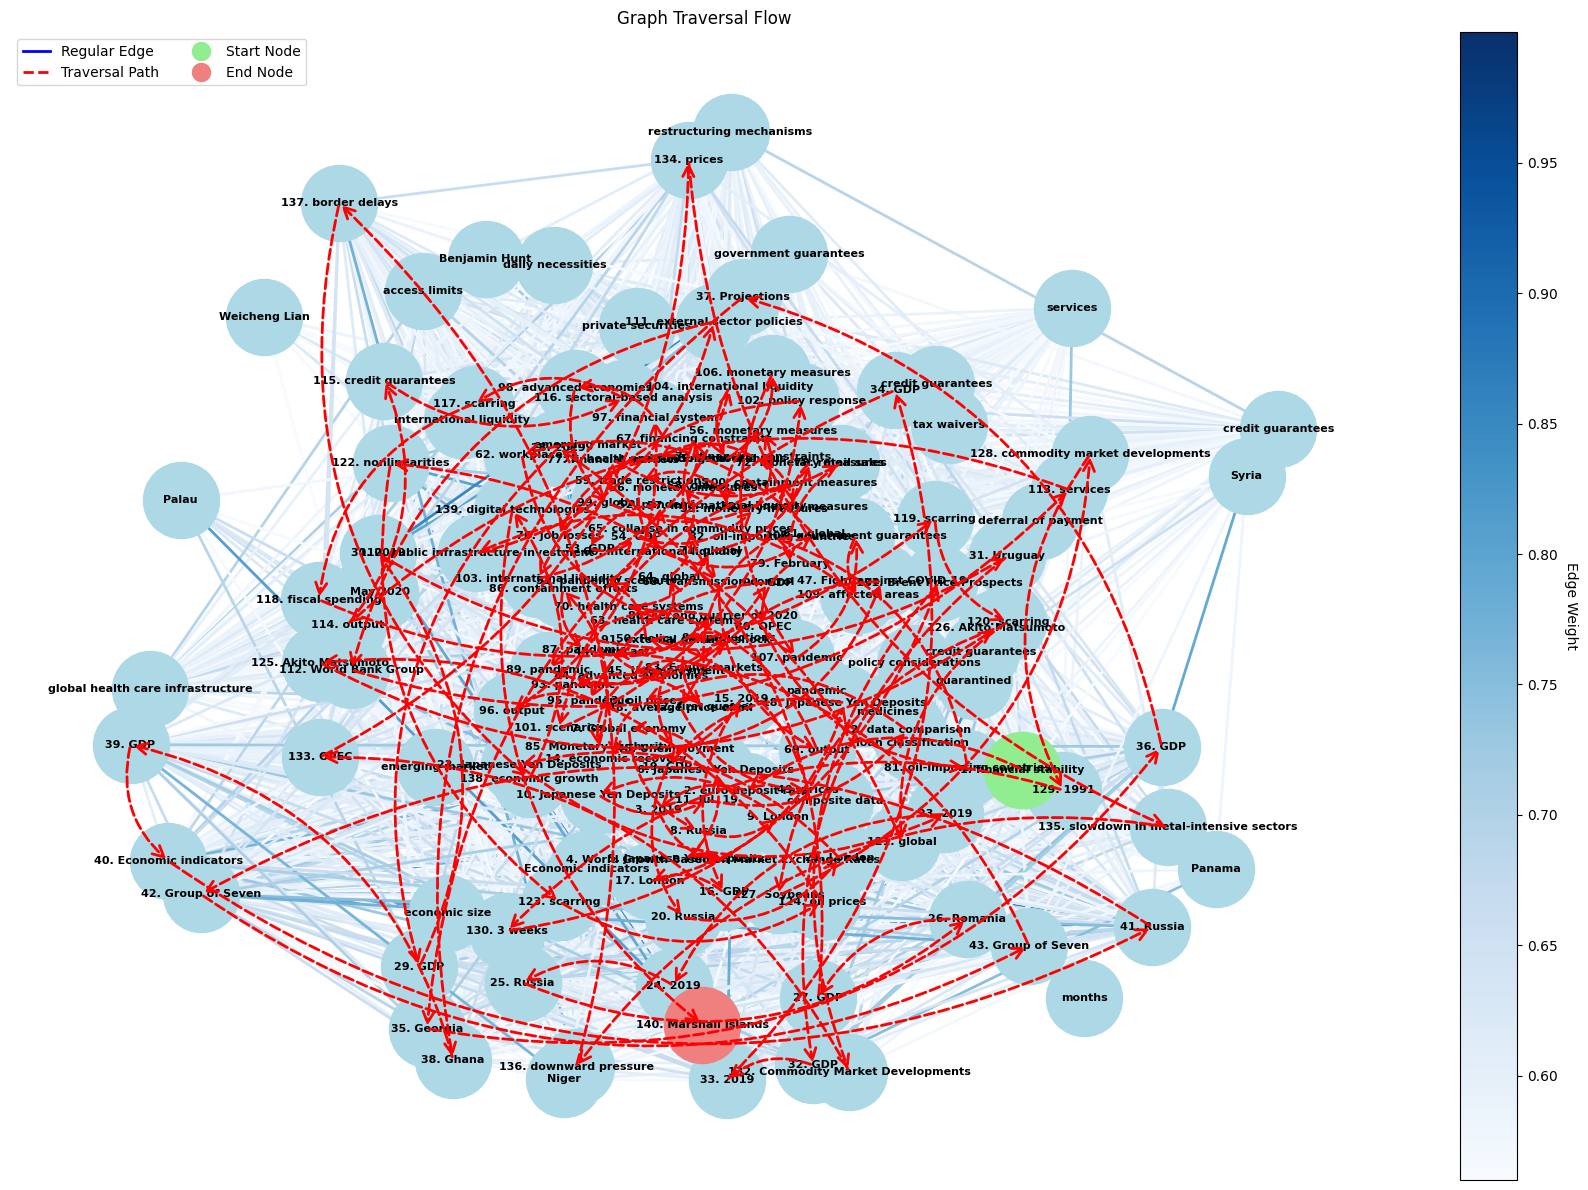

In [10]:
query="what was the economic outlook for Germany in 2020?"
response = graph_rag.query(query=query)

In [ ]:
#-----------------------------------------
# WEB SCRAPING. Ukraine News Frontline Infos
# Sources / websites: https://euromaidanpress.com/, https://militaryland.net/